# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

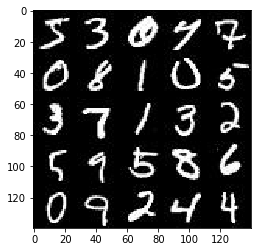

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

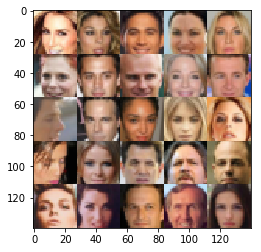

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2  # For leaky relu
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer1 = tf.maximum(alpha*layer1, layer1)  # leaky relu
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha*layer2, layer2)
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=1, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha*layer3, layer3)
        
        layer4 = tf.layers.conv2d(layer3, 512, 5, strides=1, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=True)
        layer4 = tf.maximum(alpha*layer4, layer4)
        
        flattened = tf.reshape(layer4, (-1, 7*7*512))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2  # For leaky relu
    reuse = False if is_train==True else True
    
    with tf.variable_scope('generator', reuse=reuse):
        layer1 = tf.layers.dense(z, 7*7*512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=1, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=1, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha*layer3, layer3)
        
        layer4 = tf.layers.conv2d_transpose(layer3, 64, 5, strides=2, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.maximum(alpha*layer4, layer4)

        logits = tf.layers.conv2d_transpose(layer4, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
  
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, learning_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1                
                batch_images = batch_images * 2  #  dataset in range of -0.5 to 0.5 & we want -1 to 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))  # Sample random noise for G
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_r: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_r: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    print("Step: {}".format(steps))
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)          

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4693... Generator Loss: 1.1707
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 0.7503... Generator Loss: 12.1637
Epoch 1/2... Discriminator Loss: 3.8271... Generator Loss: 0.0512
Epoch 1/2... Discriminator Loss: 4.2592... Generator Loss: 0.0202
Epoch 1/2... Discriminator Loss: 2.6653... Generator Loss: 0.1237
Epoch 1/2... Discriminator Loss: 2.3789... Generator Loss: 0.1702
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.5312
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 1.9788... Generator Loss: 0.2145
Step: 100


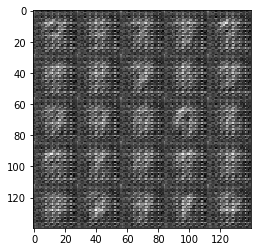

Epoch 1/2... Discriminator Loss: 3.2206... Generator Loss: 7.6043
Epoch 1/2... Discriminator Loss: 2.1747... Generator Loss: 5.4418
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 4.7548
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 5.3383
Epoch 1/2... Discriminator Loss: 1.6676... Generator Loss: 5.3018
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 3.3774
Epoch 1/2... Discriminator Loss: 0.5431... Generator Loss: 3.5526
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 2.4745
Epoch 1/2... Discriminator Loss: 0.5808... Generator Loss: 3.5724
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 4.5308
Step: 200


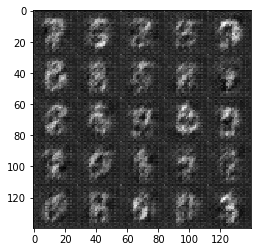

Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 3.1429
Epoch 1/2... Discriminator Loss: 0.3621... Generator Loss: 2.7082
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.4384
Epoch 1/2... Discriminator Loss: 0.5483... Generator Loss: 1.4208
Epoch 1/2... Discriminator Loss: 0.3468... Generator Loss: 2.4424
Epoch 1/2... Discriminator Loss: 2.4036... Generator Loss: 6.7272
Epoch 1/2... Discriminator Loss: 0.3166... Generator Loss: 1.8217
Epoch 1/2... Discriminator Loss: 2.0334... Generator Loss: 0.2463
Epoch 1/2... Discriminator Loss: 0.3319... Generator Loss: 1.6917
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 0.7598
Step: 300


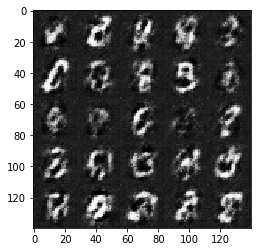

Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 1.6685
Epoch 1/2... Discriminator Loss: 0.2630... Generator Loss: 1.9946
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 3.6368
Epoch 1/2... Discriminator Loss: 1.4241... Generator Loss: 4.9507
Epoch 1/2... Discriminator Loss: 0.3170... Generator Loss: 2.0869
Epoch 1/2... Discriminator Loss: 0.2812... Generator Loss: 2.1281
Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 4.6902
Epoch 1/2... Discriminator Loss: 0.3666... Generator Loss: 1.8753
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.3155
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 0.7871
Step: 400


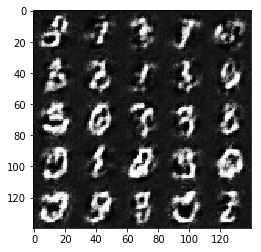

Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 2.0786
Epoch 1/2... Discriminator Loss: 0.5470... Generator Loss: 1.0942
Epoch 1/2... Discriminator Loss: 0.4173... Generator Loss: 1.6964
Epoch 1/2... Discriminator Loss: 2.3698... Generator Loss: 0.1388
Epoch 1/2... Discriminator Loss: 0.3717... Generator Loss: 2.1281
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 0.4285... Generator Loss: 2.5142
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 2.4849
Epoch 2/2... Discriminator Loss: 0.4167... Generator Loss: 1.6705
Epoch 2/2... Discriminator Loss: 0.5669... Generator Loss: 1.1042
Step: 500


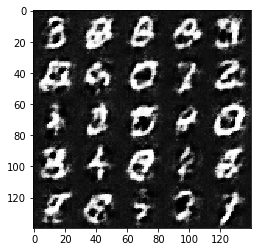

Epoch 2/2... Discriminator Loss: 0.4027... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 0.4917... Generator Loss: 1.2062
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 1.8261... Generator Loss: 0.2819
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 2.2870
Epoch 2/2... Discriminator Loss: 0.4259... Generator Loss: 1.5511
Epoch 2/2... Discriminator Loss: 0.3751... Generator Loss: 1.6486
Epoch 2/2... Discriminator Loss: 1.5025... Generator Loss: 4.7215
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 0.9735
Epoch 2/2... Discriminator Loss: 0.6830... Generator Loss: 0.8859
Step: 600


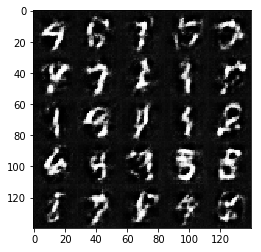

Epoch 2/2... Discriminator Loss: 0.8715... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 0.4509... Generator Loss: 1.4094
Epoch 2/2... Discriminator Loss: 2.2553... Generator Loss: 0.1535
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 0.5610... Generator Loss: 1.4452
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 0.9615
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 1.2758
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 3.7559
Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 4.7557
Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 0.7850
Step: 700


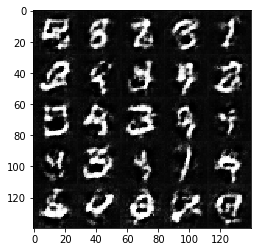

Epoch 2/2... Discriminator Loss: 0.8635... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 0.4718... Generator Loss: 1.3352
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 3.2241
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 0.7601
Epoch 2/2... Discriminator Loss: 0.4715... Generator Loss: 1.3373
Epoch 2/2... Discriminator Loss: 0.5073... Generator Loss: 1.2455
Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 1.3389
Epoch 2/2... Discriminator Loss: 0.6404... Generator Loss: 1.1139
Epoch 2/2... Discriminator Loss: 0.4650... Generator Loss: 1.4422
Epoch 2/2... Discriminator Loss: 0.7380... Generator Loss: 2.8572
Step: 800


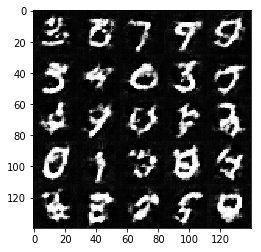

Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 2.7951
Epoch 2/2... Discriminator Loss: 0.5792... Generator Loss: 1.3528
Epoch 2/2... Discriminator Loss: 0.6315... Generator Loss: 1.0506
Epoch 2/2... Discriminator Loss: 0.5081... Generator Loss: 1.2903
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 0.8486
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 0.8146
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 0.4911... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 6.3123... Generator Loss: 8.3833
Step: 900


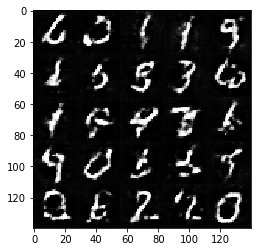

Epoch 2/2... Discriminator Loss: 1.7327... Generator Loss: 3.6192
Epoch 2/2... Discriminator Loss: 0.6364... Generator Loss: 1.9035
Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 0.8413


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 8.2894
Epoch 1/1... Discriminator Loss: 3.8388... Generator Loss: 0.0431
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 4.0830
Epoch 1/1... Discriminator Loss: 5.5702... Generator Loss: 19.3442
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 2.4670... Generator Loss: 0.1105
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 4.3175
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 3.5429
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 3.3145
Step: 100


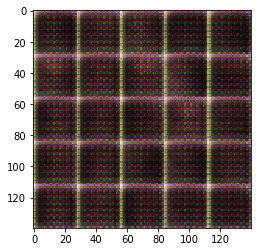

Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 2.8280
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 3.4987
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 2.4136
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 2.7606
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 3.0613
Epoch 1/1... Discriminator Loss: 1.7943... Generator Loss: 3.4630
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 2.5587
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 2.9130
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 2.3119
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 2.3006
Step: 200


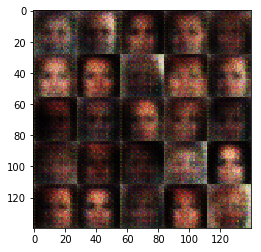

Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.8300
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 2.4822
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.7147
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.8447
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 2.6338
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 2.0893
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 1.7561
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 2.1769
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.5294
Step: 300


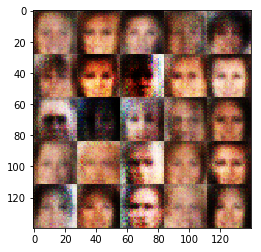

Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 2.0710
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 2.1782
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 2.2570
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 2.1651
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 1.7632
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.9024
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 2.1832
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 1.7957
Step: 400


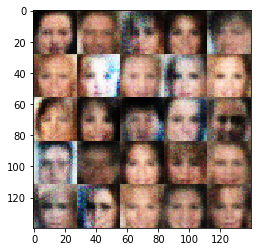

Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 1.8974
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.5903
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 2.3154
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 1.5689
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 1.6595
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.5449
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 1.7740
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.6105
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 2.1626
Step: 500


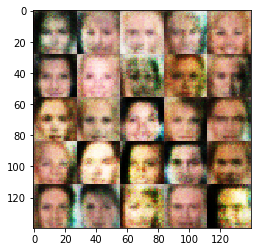

Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.8233
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 2.0881
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 1.9468
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.3098
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.4060
Step: 600


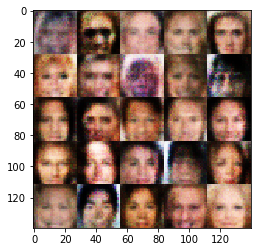

Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.3743
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.2862
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.3646
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.3788
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.3424
Step: 700


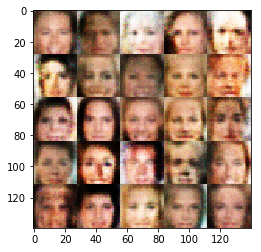

Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.2921
Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 0.2582
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.3116
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.2830
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 1.4523
Epoch 1/1... Discriminator Loss: 2.4088... Generator Loss: 0.1109
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.4997
Step: 800


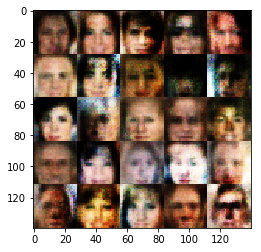

Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.6557... Generator Loss: 0.2577
Epoch 1/1... Discriminator Loss: 1.8434... Generator Loss: 0.2121
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.3095
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.5853
Step: 900


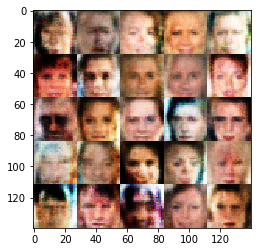

Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.3124
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.3604
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.2547
Epoch 1/1... Discriminator Loss: 0.4416... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 1.4429
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.5419
Step: 1000


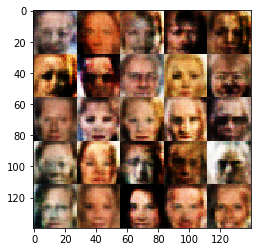

Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 2.4600... Generator Loss: 0.1346
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 2.3405
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 5.1611
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 4.5950
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 2.6319
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 2.5459
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 3.3120
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 2.4401
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 3.0371
Step: 1100


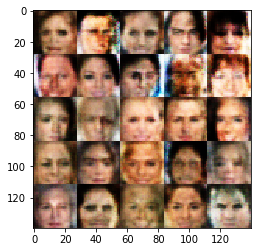

Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 3.7272
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 3.5616
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 2.0014
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 2.9096
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 3.4620
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 3.1430
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 4.0933
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 2.9558
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 3.5078
Step: 1200


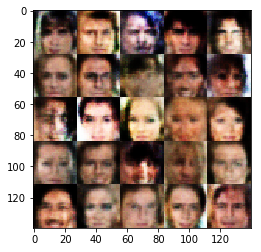

Epoch 1/1... Discriminator Loss: 0.2649... Generator Loss: 2.3522
Epoch 1/1... Discriminator Loss: 0.3233... Generator Loss: 3.9054
Epoch 1/1... Discriminator Loss: 1.9569... Generator Loss: 3.6392
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 2.4778
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 2.5379
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 3.4870
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 3.6050
Epoch 1/1... Discriminator Loss: 0.2852... Generator Loss: 2.4600
Step: 1300


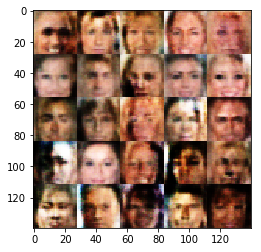

Epoch 1/1... Discriminator Loss: 0.2633... Generator Loss: 2.0620
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 3.8006
Epoch 1/1... Discriminator Loss: 0.3289... Generator Loss: 2.3015
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 4.1959
Epoch 1/1... Discriminator Loss: 0.2582... Generator Loss: 3.2838
Epoch 1/1... Discriminator Loss: 0.2118... Generator Loss: 3.4379
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 3.7763
Step: 1400


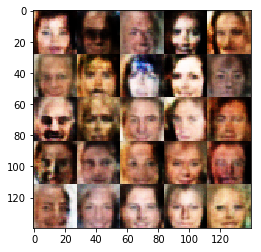

Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 6.2035
Epoch 1/1... Discriminator Loss: 1.7112... Generator Loss: 1.9467
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 2.8970
Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 2.0538
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 5.8095
Epoch 1/1... Discriminator Loss: 2.2059... Generator Loss: 2.7729
Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 3.2728
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 2.6903
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 3.5271
Step: 1500


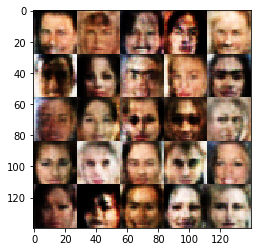

Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 2.3321
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 3.6628
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 2.3591


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.